# Installation 

* git clone https://github.com/hemantaph/gwsnr.git
* cd gwsnr .
* python setup.py install.

In [1]:
import numpy as np
import pylab as plt
from datetime import datetime

# modified Findchirp method, or Half Scaling method. 
* SNR : $$ \rho= \left( \frac{1 Mpc}{D_{eff}} \right)\mathcal{A}_{1Mpc} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Half scaled SNR : $$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right)\mathcal{A}_{1Mpc}^{-1} \times \rho $$
                    $$ \rho_{1/2} = \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$
                    
* It shouldn't depend on the GW parameters
* It depends on the noise curve of the detector : $S_n(f)$

# taking care of units
* $\mathcal{M}$ : chirp mass in $M_{\odot}$, $\mathcal{D}$: luminosity distance in Mpc. 
* $F_+,F_{\times}$: Antenna pattern, $\iota$: inclination angle
$$\mathcal{A}_{1Mpc}=\left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{\mathcal{M}}{M_{\odot}}\right)^{5/6} $$
$$ \mathcal{D}_{eff} = \mathcal{D}\left[ F_+^2\left(\frac{1+cos^2\iota}{2}\right)^2 + F_{\times}^2 cos^2\iota \right]^{-1/2} $$ 

* Half scaled SNR : 
$$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right) \mathcal{M}^{-5/6} \times \rho $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Putting a upper integration limit at $f_{ISCO}$ lower limit to a chosen $f_{min}$
$$ f_{ISCO} = \frac{f c^3}{ G M_{tot}\pi 6^{3/2} } $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_{f_{min}}^{f_{ISCO}} \frac{f^{-7/3}}{S_n(f)}df } $$

In [2]:
from gwsnr import GWSNR as snr

In [3]:
# nsamples is use for fitting. default: nsamples=100
# nsamples with higher value will give better result.
# for BNS events nsamples can be kept low
# with defult bilby's psd
snr_ = snr(npool=int(4), mtot_min=2., mtot_max=439.6, nsamples_mtot=200, nsamples_mass_ratio=500, \
                 sampling_frequency=4096.,\
                 waveform_approximant = 'IMRPhenomD', minimum_frequency = 20., \
                 snr_type = 'interpolation', waveform_inspiral_must_be_above_fmin=False)

Given: IMR waveform
psds not given. Choosing bilby's default psds
getting stored interpolator...
In case if you need regeneration of interpolator of the given gwsnr param, please delete this file, ./interpolator_pickle/halfSNR_dict_2.pickle


## simple performance checks
* the taylorF2 results are trucated at the f_max

In [4]:
# Bilby
snr_.compute_bilby_snr_(mass_1=np.array([10.,50.,100.]), mass_2=np.array([10.,50.,100.]))

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.64it/s]


{'L1': array([126.70396042, 429.63564752, 703.0618793 ]),
 'H1': array([ 80.58284938, 273.24532365, 447.14253081]),
 'V1': array([ 37.52216402, 129.97904764, 215.62974384]),
 'opt_snr_net': array([154.77532747, 525.49438565, 860.65593324])}

In [5]:
# with interpolation
snr_.snr(mass_1=np.array([10.,50.,100.]), mass_2=np.array([10.,50.,100.]))

{'opt_snr_net': array([154.75253917, 525.49407154, 860.65729984]),
 'L1': array([126.68154731, 429.63537969, 703.06306899]),
 'H1': array([ 80.5685948 , 273.24515331, 447.14328744]),
 'V1': array([ 37.5344573 , 129.97902113, 215.62975047])}

* notice how SNR decrease with mass
* mtot=1000 has $f_{lso}(f_{max})$ below 20Hz
* last stable orbit's frequency is calculated as, $f_{lso} = \frac{C^3}{ G(m_{tot})M_\odot\pi 6^{3/2} }$

# speed test
* bilby Vs interpolation with half SNR

In [6]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 1000
chirp_mass = np.linspace(5,80,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [7]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_ = snr_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

100%|███████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.74it/s]

Duration: 0:01:25.357013


* here is bilby is faster than usual as I have initialized the interferometer objects and PSDs commonly 
* multiprocessing is used here

In [8]:
start_time = datetime.now()
mine_ = snr_.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, iota=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.155730


In [9]:
(1*60+31.464921)/0.125144

730.8773972383814

* interpolation is 730.8773972383814 times faster than that of bilby's (with 4 cores' calculation)

## Accuracy checks
* SNR difference

In [10]:
mtot_min=2.
mtot_max=439.6
idx = (total_mass<=mtot_min)&(total_mass>=mtot_max)
bilby_['opt_snr_net'][idx] = 0.

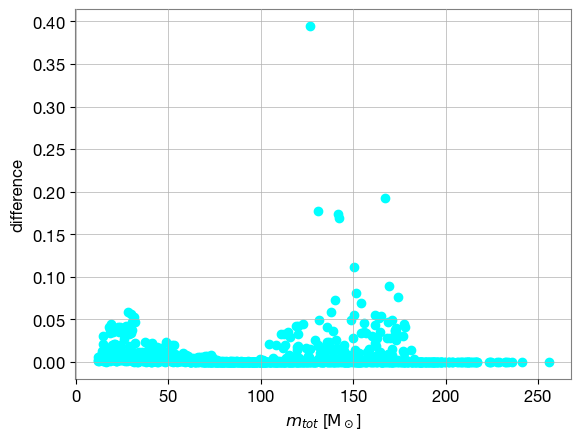

In [11]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.show()

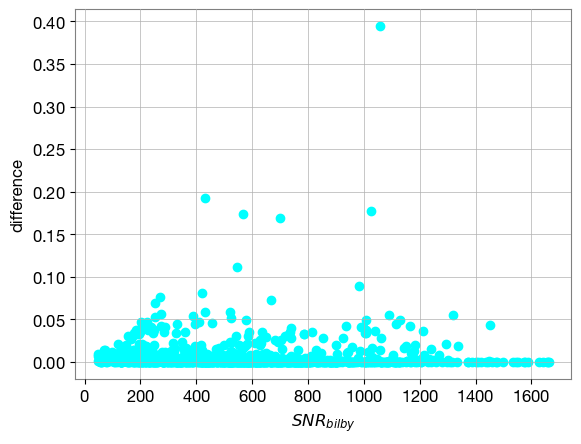

In [12]:
plt.plot(bilby_['opt_snr_net'], abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$SNR_{bilby}$")
plt.ylabel(r"difference")
plt.show()

* close enough

## Accuracy checks in BNS events
* Assumptions 
    * mass range $1-3M_{\odot}$

In [3]:
import numpy as np
import pylab as plt
from datetime import datetime

In [36]:
from gwsnr import GWSNR as snr

# nsamples_mtot=100, nsamples_mass_ratio=50 will suffice for BNS events
snr_ = snr(npool=int(4), mtot_min=2., mtot_max=16.0, nsamples_mtot=100, nsamples_mass_ratio=50, \
                 sampling_frequency=2048.,\
                 waveform_approximant = 'TaylorF2', minimum_frequency = 20., \
                 snr_type = 'interpolation', waveform_inspiral_must_be_above_fmin=False)

Given: Inspiral waveform
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/halfSNR_dict_2.pickle
Interpolator will be generated for H1 detector at ./interpolator_pickle/H1/halfSNR_dict_2.pickle
Interpolator will be generated for V1 detector at ./interpolator_pickle/V1/halfSNR_dict_2.pickle
Generating interpolator for ['L1', 'H1', 'V1'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [00:49<00:00,  1.02it/s]

interpolator generated


In [37]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20.
nsamples = 1000
total_mass = np.random.uniform(2,6,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = total_mass/(1+mass_ratio)
mass_2 = total_mass-mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [38]:
start_time = datetime.now()
bilby_ = snr_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.98it/s]

Duration: 0:00:12.429004


In [39]:
start_time = datetime.now()
mine_ = snr_.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, iota=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.124521


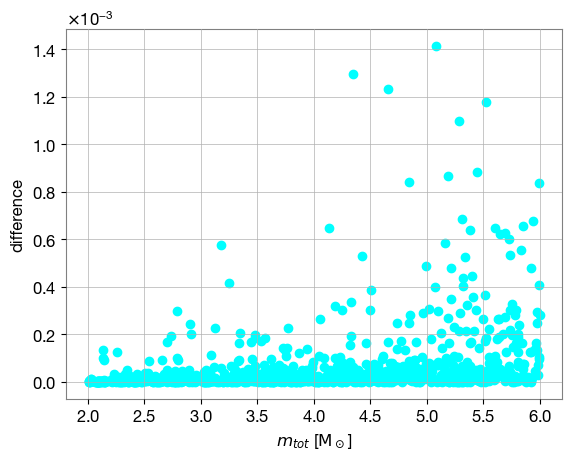

In [40]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net'])/, 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.show()